In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import Image

import seaborn as sns
import time
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp
import pandas as pd
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

from scipy import stats

In [2]:
%load_ext cython
%load_ext rpy2.ipython


R[write to console]: Warning:
R[write to console]:  namespace ‘pbdZMQ’ is not available and has been replaced
by .GlobalEnv when processing object ‘.pbd_env’

/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/ekvall/anaconda3/envs/my-r-env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

R[write to console]: Loading required package: ggplot2

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/devtools_2.3.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 375227 bytes (366 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [4]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [5]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

def runFastPerm(X_list, y_list):
    pfp_list = list()
    TIME = list()
    
    for Xp, yp in zip(X_list, y_list):

        p_fp = list()
        time_list = list()
        
        for x, y in zip(Xp, yp):
           
            start = time.time()
            p_fp.append(fastPerm(np.array(y)[np.newaxis,...], np.array(x)[np.newaxis,...]))
            end = time.time()
        
            time_list.append(end - start)
        
        pfp_list.append(p_fp)
        TIME.append(time_list)
        
    return pfp_list, TIME

In [17]:
def p_value_calc(args):
    a,b, bins = args
    p=significance_of_mean(a,b, bins)[0]
    return p

### Load data from MC approximation of permutation test

In [ ]:
def loadMcResult(sampleShape, mean):
    X_list = list()
    y_list = list()
    p_val_list = list()
    time_listMc = list()
    for S in sampleShape:
        X = pd.read_csv("dataFastPerm/data_{}/X_{}.csv".format(mean, S))
        Y = pd.read_csv("dataFastPerm/data_{}/y_{}.csv".format(mean, S))
        p_val = pd.read_csv("dataFastPerm/data_{}/error_{}.csv".format(mean, S))
        timeMc = pd.read_csv("dataFastPerm/data_{}/Time_{}.csv".format(mean, S))
    
    
        X.columns = range(X.shape[1])
        Y.columns = range(Y.shape[1])
        p_val.columns = range(p_val.shape[1])
        timeMc.columns = range(timeMc.shape[1])
    
    
        X_list.append([np.array(x.split(" ")[1:]).astype(float) for x in X[0].values])
        y_list.append([np.array(y.split(" ")[1:]).astype(float) for y in Y[0].values])
        p_val_list.append(np.array([float(p[0].split(" ")[1]) for p in p_val.values]))
        time_listMc.append([float(t[0].split(" ")[1]) for t in timeMc.values])
    
    return X_list, y_list, p_val_list, time_listMc

### Get p-value for the the parallelized permutation test

In [6]:
def run_test(X,Y,bins, parallel=True, midP=False):
    if parallel:
        #Exact test
        SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64)
        SGM.run(X.reshape(1,-1),Y.reshape(1,-1), midP)
        p_val = [2 * min( p, (1-p)) for p in SGM.get_p_values()][0]
    else:
        p_val = p_value_calc([list(X), list(Y), bins])

    return p_val

### Get all p-values from the prallelized exact test from the same data as the MC version

In [7]:
def shiftMethod(X_list, y_list, bins, parallel=True, midP=False):
    pt_list = list()
    pe_list = list()
    TIME = list()

    for Xp, yp in zip(X_list, y_list):
        p_t = list()
        p_e = list()
        time_list = list()
    
        for x, y in zip(Xp, yp):
            
            
            t, p = ttest_ind(y, x)
            
       
            p_t.append(p)
        
            start = time.time()
            p_e.append(run_test(y, x, bins, parallel, midP))
            end = time.time()
        
            time_list.append(end - start)
    
        pt_list.append(p_t)
        pe_list.append(p_e)
        TIME.append(time_list)
    
    return pt_list, pe_list, TIME
    

### Compare parallelized and MC version

In [ ]:
def compare(p_val_list, pe_list, pt_list):
    PE_err = list()
    PAE_err = list()
    
    for P_ae, P_e, P_t in zip(p_val_list, pe_list, pt_list):
        P_ae_error = list()
        P_e_error = list()
        
        for ae, e, t in zip(P_ae, P_e, P_t):
            P_ae_error.append((ae - t) / t)
            P_e_error.append((e - t) / t)
            
        PE_err.append(P_e_error)
        PAE_err.append(P_ae_error)
    
    return PE_err, PAE_err


### Boxplot

In [ ]:
def boxPlot(error, Bin, log=False, path=None):
    my_dict = dict()
    for d, b in zip(error, Bin):
        my_dict[str(b)] = d
    
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    
    plt.ylabel(r"$\frac{p_{e}-p_{t}}{p_{t}}$",fontsize=20)
        
        
    plt.xlabel("Sample size",fontsize=15)
   
    if log:
        RANGE = np.arange(np.floor(np.min(error)), np.ceil(np.max(error)))
        ax.set_yticks(RANGE)
        ax.set_yticklabels(10.0**RANGE)

    
    if path:
        fig.savefig(path+".jpg", bbox_inches='tight')
        
    

### Time-plot

In [44]:
def preparePandas(timeData, sampleSizes, test="Parallel"):
    preparePd = list()
    for time, sample in zip(timeData, sampleSizes):
        for t in time:
        
            preparePd.append([str(test),t, sample])
    return preparePd
    
    

In [45]:
def timePlotSNSFastperm(TIMEParallel, TIME_MC, sampleShape, log=False, TIMEsingleThred=False, path=None):

    sns.set(style="white")
    sns.set_context("talk")
    
    preparePdParallel = preparePandas(TIMEParallel, sampleShape, "Parallel Green")
    preparePdMc = preparePandas(TIME_MC, sampleShape, 'FastPerm')
    
    if np.any(TIMEsingleThred):
        preparePdSingle = preparePandas(TIMEsingleThred, sampleShape, 'Single thread Green')
        data = preparePdMc + preparePdParallel + preparePdSingle
    else:
        data = preparePdMc + preparePdParallel
        
    pdData = pd.DataFrame(data, columns=['Method', 'time(s)','n'])
    
    if log:        
        MAX = max(np.max(TIMEParallel), np.max(TIME_MC))
        MIN = min(np.min(TIMEParallel), np.min(TIME_MC))
        if np.any(TIMEsingleThred):
            MAX = max(np.max(TIMEParallel), np.max(TIME_MC), np.max(TIMEsingleThred))
            MIN = min(np.min(TIMEParallel), np.min(TIME_MC), np.min(TIMEsingleThred))
            
        
        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        
        snsPlot = sns.lineplot(x="n", y="time(s)",
             hue="Method",
             data=pdData)
        plt.yticks(RANGE, 10.0**RANGE)
        
        
    else:
        snsPlot = sns.lineplot(x="n", y="time(s)",
             hue="Method",
             data=pdData)
        
        
    h,l = snsPlot.get_legend_handles_labels()
    plt.legend(h[1:],l[1:])

    plt.ylabel("time(s)",fontsize=20)
        
        
    plt.xlabel(r"$n$",fontsize=15)

    plt.tight_layout()
    if path:
        
        fig = snsPlot.get_figure()


        fig.savefig(path)




In [ ]:
def timePlot(TIMEParallel, TIME_MC, sampleShape, path=None, log=False, TIMEsingleThred=None):
    plt.plot(sampleShape, np.mean(TIMEParallel,axis=1), 'r-', label='Parallelization of P-value')
    plt.plot(sampleShape, np.mean(TIME_MC,axis=1), 'g-', label='Approximation of P-value')
    if np.any(TIMEsingleThred):
        plt.plot(sampleShape, np.mean(TIMEsingleThred,axis=1), 'y-', label='Single thread shift method of P-value')
        
    plt.legend(loc='upper left')
    plt.xlabel(r"Sample size")
    if log:        
        MAX = max(np.max(TIMEParallel), np.max(TIME_MC))
        MIN = min(np.min(TIMEParallel), np.min(TIME_MC))
        if np.any(TIMEsingleThred):
            MAX = max(np.max(TIMEParallel), np.max(TIME_MC), np.max(TIMEsingleThred))
            MIN = min(np.min(TIMEParallel), np.min(TIME_MC), np.min(TIMEsingleThred))
            
        
        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        plt.yticks(RANGE, 10.0**RANGE)
            
    plt.ylabel("Time(s)")
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()

In [36]:
def getPATH(path, suffix, prefix):
    return path + '/'+ suffix + '_' + prefix + ".png"

In [37]:
path = "figures/paralellVsFastApprox"

## Sample sizes of X and Y

In [38]:
#sampleShape = [10,50,100,150,200,250,300]
sampleShape = [10,50]

In [39]:
mean =0.2

In [40]:
A_data,B_data = getAllSynthticData(sampleShape, mean)

# Experiment 1: with $X \sim N(5.0,1)$ and $Y\sim N(5.2,1)$

In [24]:
X_list5_2,y_list5_2= getAllSynthticData(sampleShape, mean)
pt_list5_2, pe_list5_2, parallel_TIME = shiftMethod(np.asarray(X_list5_2), np.asarray(y_list5_2), 40)

This data requires 0.045144 MiB on the GPU.
This data requires 0.052008 MiB on the GPU.
This data requires 0.053239999999999996 MiB on the GPU.
This data requires 0.044615999999999996 MiB on the GPU.
This data requires 0.047608 MiB on the GPU.
This data requires 0.054824 MiB on the GPU.
This data requires 0.038279999999999995 MiB on the GPU.
This data requires 0.049367999999999995 MiB on the GPU.
This data requires 0.052184 MiB on the GPU.
This data requires 0.046904 MiB on the GPU.
This data requires 0.049192 MiB on the GPU.
This data requires 0.057464 MiB on the GPU.
This data requires 0.051831999999999996 MiB on the GPU.
This data requires 0.052711999999999995 MiB on the GPU.
This data requires 0.06274400000000001 MiB on the GPU.
This data requires 0.048664 MiB on the GPU.
This data requires 0.046551999999999996 MiB on the GPU.
This data requires 0.040743999999999995 MiB on the GPU.
This data requires 0.041976 MiB on the GPU.
This data requires 0.04972 MiB on the GPU.
This data requ

In [46]:

p_val_list5_2, TIME_MC5_2 = runFastPerm(np.asarray(X_list5_2), np.asarray(y_list5_2))

In [47]:
singleT_pt_list5_2, singleT_pe_list5_2, singleThreadTime = shiftMethod(np.asarray(X_list5_2), np.asarray(y_list5_2), 40, False)

In [48]:
for st_l, para_l in zip(singleT_pt_list5_2,pt_list5_2):
    st_a = np.array(st_l)
    para_a = np.array(para_l)
    print(np.allclose(st_a, para_a))

True
True


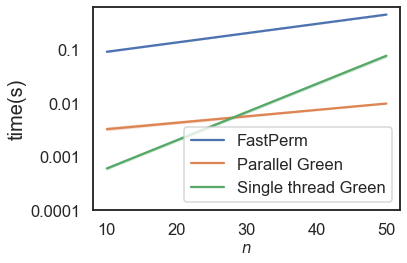

In [49]:
timePlotSNSFastperm(np.log10(parallel_TIME), np.log10(TIME_MC5_2), 
            sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),log=True, 
            TIMEsingleThred=np.log10(singleThreadTime))

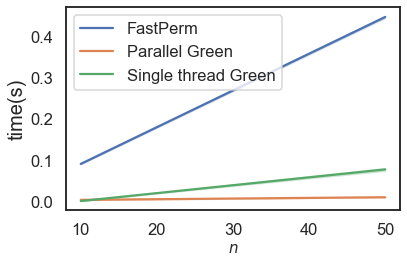

In [50]:
timePlotSNSFastperm(parallel_TIME, TIME_MC5_2, sampleShape, 
            path=getPATH(path, str(mean),"SNSruntimeSingleThread"),log=False, 
            TIMEsingleThred=singleThreadTime)




# Runtime comparison

In [ ]:
TIMEParallel5_2 = np.asarray([np.array(T) for T in TIME5_2])
TIME_MC5_2 = np.asarray([np.array(Tmc) for Tmc in time_listMc5_2])

In [ ]:
timePlotSNS(TIMEParallel5_2, TIME_MC5_2, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

In [ ]:
timePlotSNS(np.log10(TIMEParallel5_2), np.log10(TIME_MC5_2), sampleShape, 
                    path=getPATH(path, str(mean),"SNSruntimeLog"), log=True)

# Experiment 2: with $X \sim N(5.0,1)$ and $Y\sim N(5.4,1)$

In [ ]:
mean = 0.4

In [ ]:
X_list5_4, y_list5_4 = getAllSynthticData(sampleShape, mean)
pt_list5_4, pe_list5_4, TIME5_4 = shiftMethod(np.asarray(X_list5_4), np.asarray(y_list5_4), 40)



In [ ]:
p_val_list5_4, time_listMc5_4 = runFastPerm(np.asarray(X_list5_4), np.asarray(y_list5_4))

# Runtime comparison

In [ ]:
TIMEParallel5_4 = np.asarray([np.array(T) for T in TIME5_4])
TIME_MC5_4 = np.asarray([np.array(Tmc) for Tmc in time_listMc5_4])


In [ ]:
timePlotSNS(TIMEParallel5_4, TIME_MC5_4, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

In [ ]:
timePlotSNS(np.log10(TIMEParallel5_4), np.log(TIME_MC5_4), sampleShape, path=getPATH(path, str(mean),"SNSruntimeLog"), log=True)

# Experiment 3: with $X \sim N(5.0,1)$ and $Y\sim N(5.6,1)$

In [ ]:
mean=0.6

In [ ]:
X_list5_6, y_list5_6 = getAllSynthticData(sampleShape, mean)
p_val_list5_6, time_listMc5_6 = runFastPerm(np.asarray(X_list5_6), np.asarray(y_list5_6))
pt_list5_6, pe_list5_6, TIME5_6 = shiftMethod(np.asarray(X_list5_6), np.asarray(y_list5_6), 40)
PE_err5_6, PAE_err5_6 = compare(p_val_list5_6, pe_list5_6, pt_list5_6)

In [ ]:
pt_list5_6midP, pe_list5_6midP, TIME5_6midP = shiftMethod(np.asarray(X_list5_6), np.asarray(y_list5_6), 40, midP=True)
PE_err5_6midP, PAE_err5_6midP = compare(p_val_list5_6, pe_list5_6midP, pt_list5_6midP)

# Runtime comparison

In [ ]:
TIMEParallel5_6 = np.asarray([np.array(T) for T in TIME5_6])
TIME_MC5_6 = np.asarray([np.array(Tmc) for Tmc in time_listMc5_6])


In [ ]:
timePlotSNS(TIMEParallel5_6, TIME_MC5_6, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

In [ ]:
timePlotSNS(np.log10(TIMEParallel5_6), np.log10(TIME_MC5_6), sampleShape, path=getPATH(path, str(mean),"SNSruntimeLog"), log=True)

# Experiment 4: with $X \sim N(5.0,1)$ and $Y\sim N(5.8,1)$

In [ ]:
mean=0.8

In [ ]:
X_list5_8, y_list5_8 = getAllSynthticData(sampleShape, mean)
p_val_list5_8, time_listMc5_8 = runFastPerm(np.asarray(X_list5_8), np.asarray(y_list5_8))
pt_list5_8, pe_list5_8, TIME5_8 = shiftMethod(np.asarray(X_list5_8), np.asarray(y_list5_8), 40)
PE_err5_8, PAE_err5_8 = compare(p_val_list5_8, pe_list5_8, pt_list5_8)

In [ ]:
pt_list5_8midP, pe_list5_8midP, TIME5_8 = shiftMethod(np.asarray(X_list5_8), np.asarray(y_list5_8), 40, midP=True)
PE_err5_8midP, PAE_err5_8midP = compare(p_val_list5_8, pe_list5_8midP, pt_list5_8midP)

# Runtime comparison

In [ ]:
TIMEParallel5_8 = np.asarray([np.array(T) for T in TIME5_8])
TIME_MC5_8 = np.asarray([np.array(Tmc) for Tmc in time_listMc5_8])

In [ ]:
timePlotSNS(TIMEParallel5_8, TIME_MC5_8, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

In [ ]:
timePlotSNS(np.log10(TIMEParallel5_8), np.log10(TIME_MC5_8), sampleShape, path=getPATH(path, str(mean),"SNSruntimeLog"), log=True)

# Experiment 5: with $X \sim N(5.0,1)$ and $Y\sim N(6.0,1)$

In [ ]:
mean=1.0

In [ ]:
X_list6_0, y_list6_0 = getAllSynthticData(sampleShape, int(mean))
p_val_list6_0, time_listMc6_0 = runFastPerm(np.asarray(X_list6_0), np.asarray(y_list6_0))
pt_list6_0, pe_list6_0, TIME6_0 = shiftMethod(np.asarray(X_list6_0), np.asarray(y_list6_0), 40)
PE_err6_0, PAE_err6_0 = compare(p_val_list6_0, pe_list6_0, pt_list6_0)

In [ ]:
pt_list6_0midP, pe_list6_0midP, TIME6_0midP = shiftMethod(np.asarray(X_list6_0), np.asarray(y_list6_0), 40, midP=True)
PE_err6_0midP, PAE_err6_0midP = compare(p_val_list6_0, pe_list6_0midP, pt_list6_0midP)

# Runtime comparison

In [ ]:
TIMEParallel6_0 = np.asarray([np.array(T) for T in TIME6_0])
TIME_MC6_0 = np.asarray([np.array(Tmc) for Tmc in time_listMc6_0])

In [ ]:
timePlotSNS(TIMEParallel6_0, TIME_MC6_0, sampleShape, path=getPATH(path, str(mean),"SNSruntime"))

In [ ]:
timePlotSNS(np.log10(TIMEParallel6_0), np.log10(TIME_MC6_0), sampleShape, 
            path=getPATH(path, str(mean),"SNSruntimeLog"),log=True)

# Timeseries comparison with shiftMethod single thread

In [ ]:
singleT_pt_list5_2, singleT_pe_list5_2, singleT_TIME5_2 = shiftMethod(np.asarray(X_list5_2), np.asarray(y_list5_2), 40, False)

### Ensure that the single thread and parallelized version yield the same p-values

In [ ]:
for st_l, para_l in zip(singleT_pt_list5_2,pt_list5_2):
    st_a = np.array(st_l)
    para_a = np.array(para_l)
    print(np.allclose(st_a, para_a))

### Recall that the runtime for the shift method will be invaraint between all these experiemnts since all hyperparameter is constant (only different types of data).

In [ ]:
#parallel_TIME, singleThreadTime = TIMEParallel6_0, singleT_TIME6_0
parallel_TIME, singleThreadTime = TIMEParallel5_2, singleT_TIME5_2

# Runtime for experiment 1: with $X \sim N(5.0,1)$ and $Y\sim N(5.2,1)$

In [ ]:
mean = 0.2

In [ ]:
timePlotSNS(parallel_TIME, TIME_MC5_2, sampleShape, 
            path=getPATH(path, str(mean),"SNSruntimeSingleThread"),log=False, 
            TIMEsingleThred=singleThreadTime)




In [ ]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC5_2), 
            sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),log=True, 
            TIMEsingleThred=np.log10(singleThreadTime))

# Runtime for experiment 2: with $X \sim N(5.0,1)$ and $Y\sim N(5.4,1)$

In [ ]:
mean = 0.4

In [ ]:
timePlotSNS(parallel_TIME, TIME_MC5_4, sampleShape, 
         path=getPATH(path, str(mean),"SNSruntimeSingleThread"),
         log=False, TIMEsingleThred=singleThreadTime)


In [ ]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC5_4), 
            sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
            log=True, TIMEsingleThred=np.log10(singleThreadTime))


In [ ]:
TIME_MC5_2[-1]

In [ ]:
parallel_TIME[-1]

In [ ]:
sampleShape[2]

In [ ]:
x = np.mean(parallel_TIME,1)[2]
y = np.mean(TIME_MC5_2,1)[2]
y/x

In [ ]:
x = np.mean(parallel_TIME,1)[-1]
y = np.mean(TIME_MC5_2,1)[-1]
y/x

# Runtime for experiment 3: with $X \sim N(5.0,1)$ and $Y\sim N(5.6,1)$

In [ ]:
mean = 0.6

In [ ]:
timePlotSNS(parallel_TIME, TIME_MC5_6, sampleShape, 
         path=getPATH(path, str(mean),"SNSruntimeSingleThread"),log=False, 
         TIMEsingleThred=singleThreadTime)

In [ ]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC5_6), 
         sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),log=True, 
         TIMEsingleThred=np.log10(singleThreadTime))


# Runtime for experiment 4: with $X \sim N(5.0,1)$ and $Y\sim N(5.8,1)$

In [ ]:
mean = 0.8

In [ ]:
timePlotSNS(parallel_TIME, TIME_MC5_8, 
         sampleShape, path=getPATH(path, str(mean),"SNSruntimeSingleThread"),
         log=False, TIMEsingleThred=singleThreadTime)


In [ ]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC5_8), 
         sampleShape, path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
         log=True, TIMEsingleThred=np.log10(singleThreadTime))


# Runtime for experiment 5: with $X \sim N(5.0,1)$ and $Y\sim N(6.0,1)$

In [ ]:
mean = 1.0

In [ ]:
timePlotSNS(parallel_TIME, TIME_MC6_0, 
         sampleShape, path=getPATH(path, str(mean),"SNSruntimeSingleThread"),
         log=False, TIMEsingleThred=singleThreadTime)

In [ ]:
timePlotSNS(np.log10(parallel_TIME), np.log10(TIME_MC6_0), sampleShape, 
         path=getPATH(path, str(mean),"SNSruntimeLogSingleThread"),
         log=True, TIMEsingleThred=np.log10(singleThreadTime))

In [ ]:
np.mean(parallel_TIME,axis=1)[-1]

In [ ]:
np.mean(TIME_MC6_0, axis=1)[-1]

In [ ]:
np.mean(TIME_MC6_0, axis=1)[-1] / np.mean(parallel_TIME,axis=1)[-1]

In [ ]:
1.269431604 * 20_000 / 3600

In [ ]:
0.2782923173904419 * 20_000 / 3600